# Anomaly Detection in Network Traffic with K-means clustering

We can categorize machine learning algorithms into two main groups: **supervised learning** and **unsupervised learning**. With supervised learning algorithms, in order to predict unknown values for new data, we have to know the target value for many previously-seen examples. In contrast, unsupervised learning algorithms explore the data which has no target attribute to find some intrinsic structures in them.

Clustering is a technique for finding similar groups in data, called **clusters**. Clustering is often called an unsupervised learning task as no class values denoting an a priori grouping of the data instances are given.

In this notebook, we will use K-means, a very well known clustering algorithm to detect anomaly network connections based on statistics about each of them. For a thorough overview of K-means clustering, from a research perspective, have a look at this wonderful [tutorial](http://theory.stanford.edu/~sergei/slides/kdd10-thclust.pdf).

## Goals
We expect students to:
* Learn (or revise) and understand the K-means algorithm
* Implement a simple K-means algorithm
* Use K-means to detect anomalies network connection data

## Steps

1. In section 1, we will have an overview about K-means then implement a simple version of it.
2. In section 2, we build models with and without categorical features.
3. Finally, in the last section, using our models, we will detect unsual connections.

# 1. K-means
## 1.1. Introduction
Clustering is a typical and well-known type of unsupervised learning. Clustering algorithms try to find natural groupings in data. Similar data points (according to some notion of similarity) are considered in the same group. We call these groups **clusters**.

K-Means clustering is a simple and widely-used clustering algorithm. Given value of $k$, it tries to build $k$ clusters from samples in the dataset. Therefore, $k$ is an hyperparameter of the model. The right value of $k$ is not easy to determine, as it highly depends on the data set and the way that data is featurized.

To measue the similarity between any two data points, K-means requires the definition of a distance funtion between data points. What is a distance? It is a value that indicates how close two data points are in their space. In particular, when data points lie in a $d$-dimensional space, the Euclidean distance is a good choice of a distance function, and is supported by MLLIB.

In K-means, a cluster is a group of points, with a representative entity called a centroid. A centroid is also a point in the data space: the center of all the points that make up the cluster. It's defined to be the arithmetic mean of the points. In general, when working with K-means, each data sample is represented in a $d$-dimensional numeric vector, for which it is easier to define an appropriate distance function. As a consequence, in some applications, the original data must be transformed into a different representation, to fit the requirements of K-means.

## 1.2. How does it work ?
Given $k$, the K-means algorithm works as follows:

1. Randomly choose $k$ data points (seeds) to be the initial centroids
2. Assign each data point to the **closest centroid**
3. Re-compute (update) the centroids using the current cluster memberships
4. If a convergence criterion is not met, go to step 2

We can also terminate the algorithm when it reaches an iteration budget, which yields an approximate result.
From the pseudo-code of the algorithm, we can see that K-means clustering results can be sensitive to the order in which data samples in the data set are explored. A sensible practice would be to run the analysis several times, randomizing objects order; then, average the cluster centres of those runs and input the centres as initial ones for one final run of the analysis.

## 1.3. Illustrative example
One of the best ways to study an algorithm is trying implement it.
In this section, we will go step by step to implement a simple K-means algorithm.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

### Question 1

#### Question 1.1
<div class="alert alert-info">

Complete the below function to calculate an euclidean distance between any two points in $d$-dimensional data space

</div>

In [1]:
import numpy as np

# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1)-np.array(p2))

# test our function
assert (round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"

### Instead of using the normal calculation like this : $$np.sqrt(np.sum((np.array(p1)-np.array(p2))**2))$$We take advantage of the norm() function in numpy library

#### Question 1.2
<div class="alert alert-info">

Given a data point and the current set of centroids, complete the function below to find the index of the closest centroid for that data point.

</div>

In [2]:
def find_closest_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    Dist_to_centroid = np.array(list(map(lambda x: euclidean_distance(x , datapoint), centroids)))
    print (Dist_to_centroid)
    cen_idx = np.where(Dist_to_centroid==Dist_to_centroid.min())[0]
    return cen_idx

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"


[ 1.41421356  1.          2.23606798]


### Dist_each_point is a list of distance of a point to each centroid
### Then return the order of the centroid which has the smallest distance

#### Question 1.3
<div class="alert alert-info">

Write a function to randomize `k` initial centroids.

</div>

In [10]:
np.random.seed(22324)

# randomize initial centroids
def randomize_centroids(data, k):
    np.random.seed()
    np.random.shuffle(data)
    return data[:k]

assert(len(
    randomize_centroids(
        np.array([ 
            np.array([2,1,2]), 
            np.array([1,2,1]), 
            np.array([3,1,2]) 
             ]), 
        2)) == 2), "Wrong function"

#### Question 1.4
<div class="alert alert-info">

Write function `check_converge` to check the stop creteria of the algorithm.

</div>

In [11]:
MAX_ITERATIONS = 100

# return True if clusters have converged , otherwise, return False  
def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    if num_iterations >= MAX_ITERATIONS:
        return True
    # check if the centroids don't move (or very slightly)
    delta_dist_list = np.array(list(map(lambda i: euclidean_distance(centroids[i] , old_centroids[i]), range(0,len(centroids)))))
    sumDist = delta_dist_list.sum()
    if sumDist <= threshold:
        return True
    return False

### delta_dist_list is a list of how much each centroid changes its distance

#### Question 1.5
<div class="alert alert-info">

Write function `update_centroid` to update the new positions for the current centroids based on the position of their members.

</div>

In [12]:
# centroids: a list of centers
# cluster: a list of k elements. Each element i-th is a list of data points that are assigned to center i-th
def update_centroids(centroids, cluster):
    centroids = np.array(list(map(lambda x: np.mean(x, axis=0), cluster)))
    return centroids

#### Question 1.6
<div class="alert alert-info">

Complete the K-means algorithm scheleton below, with the functions you wrote above.

</div>

In [13]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None):
    
    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data, k)

    #old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for datapoint in data:
            # find the closest center of each data point
            centroid_idx = find_closest_centroid(datapoint, centroids)
            
            # assign datapoint to the closest cluster
            clusters[centroid_idx].append(np.array(datapoint))
        
        # keep the current position of centroids before changing them
        old_centroids = centroids[:]
        
        # update centroids
        centroids = update_centroids(centroids, clusters)
        
        # if the stop criteria are met, stop the algorithm
        if check_converge(centroids, old_centroids, iterations, threshold=0) == True:
            break
    
    return centroids


Next, we will test our algorithm on [Fisher's Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set), and plot the resulting clusters in 3D.

#### Question 1.7
<div class="alert alert-info">

The code below can be used to test your algorithm with three different datasets: `Iris`, `Moon` and `Blob`.
Run your algorithm to cluster datapoints in these datasets, plot the results and discuss about them. Do you think that our algorithm works well? Why?

</div>

In [18]:
# the sourcecode in this cell is inspired from 
# https://gist.github.com/bbarrilleaux/9841297

%matplotlib inline

from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# load data
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
# do the clustering
centers = kmeans(X_iris, k=3)
labels = [find_closest_centroid(p, centers) for p in X_iris]

#plot the clusters in color
#fig = plt.figure(1, figsize=(8, 8))
#plt.clf()
#ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
#plt.cla()
#ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels)

# moon
# np.random.seed(0)
# X, y = datasets.make_moons(2000, noise=0.2)

# blob
# np.random.seed(0)
# X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)

# centers = kmeans(X, k=3)
# labels = [find_closest_centroid(p, centers) for p in X]

# fig = plt.figure(1, figsize=(8, 8))
# plt.clf()
# plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

#ax.w_xaxis.set_ticklabels([])
#ax.w_yaxis.set_ticklabels([])
#ax.w_zaxis.set_ticklabels([])
#ax.set_xlabel('Petal width')
#ax.set_ylabel('Sepal length')
#ax.set_zlabel('Petal length')

#plt.show()

# Here we use sci-kit learn implementation of K-means
centers2 =cluster.KMeans(n_clusters=3)
centers2.fit(X_iris) 
labels2 = centers2.labels_

[ 0.          3.68917335  2.67581763]
[ 3.68917335  0.          5.70526073]
[ 2.67581763  5.70526073  0.        ]
[ 0.77459667  3.11287648  2.79284801]
[ 2.67207784  6.10819122  1.00995049]
[ 1.58429795  2.37065392  3.92555729]
[ 3.04466747  6.08111832  0.45825757]
[ 2.79284801  5.9118525   0.34641016]
[ 2.60576284  5.82237065  0.53851648]
[ 2.49399278  5.64535207  0.37416574]
[ 1.15758369  2.59036677  3.36749165]
[ 0.57445626  3.24653662  2.80535203]
[ 1.94679223  2.12132034  3.61247837]
[ 2.87402157  6.14573023  0.6164414 ]
[ 1.4106736   2.71661554  3.14483704]
[ 1.00995049  3.1         3.14006369]
[ 1.46287388  2.37697286  3.41467422]
[ 1.55884573  2.18174242  3.80131556]
[ 3.45398321  0.54772256  5.39166023]
[ 0.3         3.47275107  2.84077454]
[ 1.44913767  2.5         3.24653662]
[ 2.6925824   6.17413962  1.12694277]
[ 0.7         3.16543836  2.85482048]
[ 2.98496231  6.47919748  1.3       ]
[ 0.58309519  3.69459064  2.33666429]
[ 2.28035085  1.67630546  4.28485706]
[ 3.40293991

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:25: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


[ 3.53637578  5.25578675  0.4673243 ]
[ 0.67723855  1.31603306  3.98757972]
[ 1.52947278  0.68026012  4.59738969]
[ 3.35427962  5.01929222  0.0599333 ]
[ 2.13018771  0.51940433  5.27802918]
[ 3.51573578  5.16105974  0.19181241]
[ 1.49690198  0.84360699  4.59839015]
[ 1.71207235  0.39972598  5.00335807]
[ 0.81030152  1.56422757  4.0684631 ]
[ 3.32717307  4.95559169  0.21815591]
[ 1.93240979  0.4954357   5.09085376]
[ 1.56314233  3.35938336  2.27868208]
[ 1.31737521  0.5373079   4.5953446 ]
[ 3.37585987  5.08596875  0.36659514]
[ 3.45576371  5.0382641   0.5287646 ]
[ 2.03705779  0.29000894  5.2614059 ]
[ 1.89864229  0.24560416  5.07992047]
[ 0.72621086  2.51864341  2.80399572]
[ 0.21176055  1.64063182  3.47148268]
[ 3.12984882  4.63136163  0.82848778]
[ 3.58713548  5.29702081  0.41230086]
[ 1.16356785  0.75841036  4.31086905]
[ 0.61198453  1.2287314   3.91887637]
[ 3.3330597   4.93879264  0.33762701]
[ 3.35867765  4.943606    0.41132955]
[ 0.79746702  1.08243834  4.10541009]
[ 3.39438163

In [27]:
print('Centroids of self-built K-means: ', labels)
print('Centroids of Sci-kit learn K-means: ', labels2)

Centroids of self-built K-means:  [array([0]), array([1]), array([2]), array([0]), array([2]), array([0]), array([2]), array([2]), array([2]), array([2]), array([0]), array([0]), array([0]), array([2]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), array([2]), array([0]), array([2]), array([0]), array([1]), array([1]), array([1]), array([2]), array([0]), array([1]), array([0]), array([2]), array([0]), array([1]), array([2]), array([1]), array([2]), array([0]), array([2]), array([1]), array([0]), array([1]), array([2]), array([2]), array([2]), array([0]), array([0]), array([0]), array([2]), array([0]), array([2]), array([0]), array([0]), array([1]), array([1]), array([0]), array([1]), array([1]), array([2]), array([2]), array([0]), array([0]), array([0]), array([0]), array([1]), array([2]), array([2]), array([2]), array([2]), array([0]), array([0]), array([2]), array([2]), array([2]), array([0]), array([1]), array([1]), array([0]), array([2]), array

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


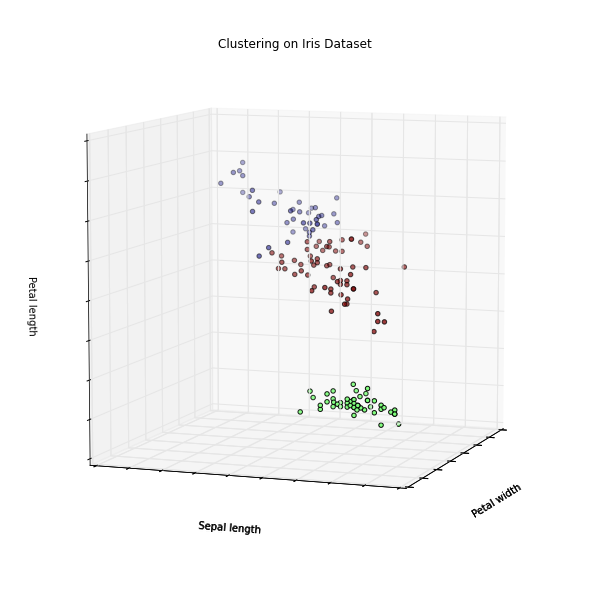

In [16]:
#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
plt.title('Clustering on Iris Dataset')
plt.show()

<div class="alert alert-warning">


PUT YOUR COMMENT HERE !!!

</div>


#### We can see that the data is a little bit clearly seperated to 3 clusters. But it seems that there is some difficulties to determine whether a point belongs to red cluster or blue cluster 
#### We think that our algorithm work fine because we can see that: points belong to one cluster seem near points in the same cluster but far away enough from points from other clusters.
#### The green cluster is clearly seperated from red cluster and blue cluster.

### To get more insight information, we would like to use PCA to calculate the 3 possible largest variances to form a 3D dimension. We expect that the new 3D will visualize better than the graph above  


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


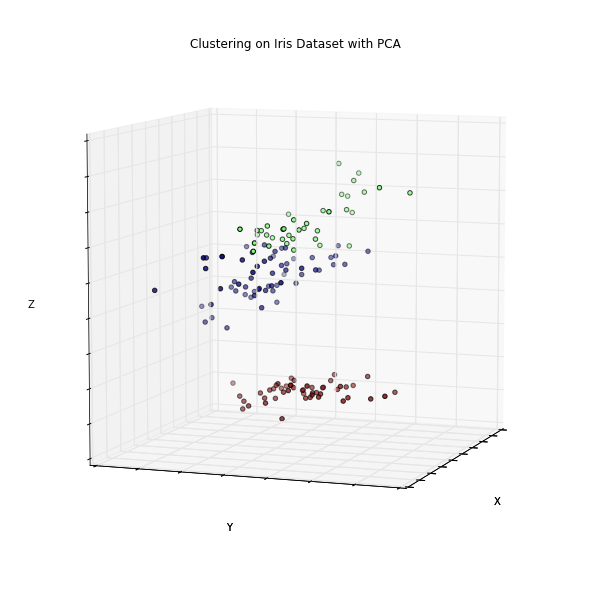

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
score = pca.fit_transform(X_iris)
PCA(copy=True, n_components=3, whiten=False)

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(score[:, 2], score[:, 1], score[:, 0], c=labels)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Clustering on Iris Dataset with PCA')
plt.show()

<div class="alert alert-warning">


PUT YOUR COMMENT HERE !!!

</div>

### In this graph, it shows that the points spread more than the previous one. It visualize better in somehow (in our opinion) 

That's enough about K-means for now. In the next section, we will apply MMLIB's K-means on Spark to deal with a large data in the real usecase.


# 2. Usecase: Network Intrusion 

Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.


## 2.1. Data
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each features, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as `su_attempted` in the 15th column. Some features are counts, like `num_file_creations` in the 17th columns. Some others are the number of sent and received bytes.

## 2.2. Clustering without using categorical features

First, we need to import some packages that are used in this notebook.

In [3]:
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from pyspark.mllib.clustering import KMeans, KMeansModel
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


input_path = "/datasets/k-means/kddcup.data"
raw_data = sc.textFile(input_path, 12)

/opt/conda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


### 2.2.1. Loading data

There are two types of features: numerical features and categorical features.
Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1**: we don't use the labels in the training phase !!!

**Note 2**: in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 2
<div class="alert alert-info">

Write function `parseLine` to construct a tuple of `(label, vector)` for each connection, extract the data that contains only the data points (without label), then print the number of connections.

</div>

Where,

* `label` is the pre-defined label of each connection
* `vector` is a numpy array that contains values of all features, but the label and the categorial features at index `1,2,3` of each connection. Each `vector` is a data point.

In [4]:
def parseLine(line):
    
    cols = line.split(",")
    # label is the last column
    label = cols[-1]
    
    # vector is every column, except the label
    vector = cols[:-1]
    
    # delete values of columns that have index 1->3 (categorical features)
    vector[1:4]=[]
    
    # convert each value from string to float
    vector = np.array(list(map(lambda x: float(x), vector)))
    return (label, vector)


labelsAndData = raw_data.map(lambda line: parseLine(line))

# we only need the data, not the labeldef parseLine(line):
data = labelsAndData.map(lambda x: x[1]).cache()

# number of connections
n = data.count()

print('number of connections: ', n)

number of connections:  4898431


In [8]:
print(data.take(1))

[array([  0.00000000e+00,   2.15000000e+02,   4.50760000e+04,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00])]


In [11]:
#Get all labels in the dataset
labels_data = labelsAndData.map(lambda x: x[0]).cache()
#Count the distribution of labels 
list_classes = []
count_classes = []
for key, value in sorted(labels_data.countByValue().items(), key = lambda x: -x[1]):
    list_classes.append(key)
    count_classes.append(value)
    print(key, value)

smurf. 2807886
neptune. 1072017
normal. 972781
satan. 15892
ipsweep. 12481
portsweep. 10413
nmap. 2316
back. 2203
warezclient. 1020
teardrop. 979
pod. 264
guess_passwd. 53
buffer_overflow. 30
land. 21
warezmaster. 20
imap. 12
rootkit. 10
loadmodule. 9
ftp_write. 8
multihop. 7
phf. 4
perl. 3
spy. 2


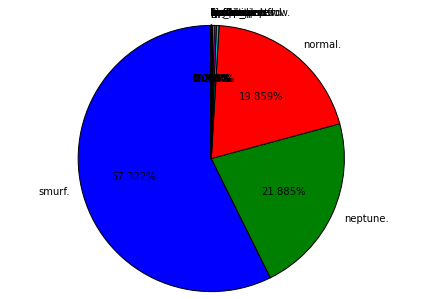

In [19]:
plt.pie(
    # using data total)arrests
    count_classes,
    # with the labels being officer names
    labels=list_classes,
    # with no shadows
    shadow=False,
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.3f%%',
    )

# View the plot drop above
plt.axis('equal')

# View the plot
plt.tight_layout()
plt.show()

### Data summarization:

#### We can see that the data has 4898431 records divided into  23 classes.
#### The top 3 largest classes: smurf (57.3%), neptune (21.9%), normal (19.9%)
#### The top 3 smallest classes: phf (8.2e-7%), perl (6.1e-7%), spy (4.1e-7%)
#### Hardly to say about the distribution of the dataset.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 3
<div class="alert alert-info">

Using K-means algorithm of MLLIB, cluster the connections into two groups then plot the result. Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

</div>  

You can use the following parameters:  

<ul>

  <li>`maxIterations=10`</li>
  <li>`runs=10`</li>
  <li>`initializationMode="random"`</li>

</ul>  

Discuss the result from your figure.

In [5]:
clusters = KMeans.train(data, 2, maxIterations=10, runs=10, initializationMode="random")

/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


### We reuse the code of visualizing data in the previous part, then putting it in the function PlotData(data,rate,clusters)

In [24]:
def PlotData(data, rate, clusters):
    sampledData = data.sample(False, rate)

    clusterCentroids = sc.parallelize(clusters.centers)
    sampledDataCentroids = sampledData + clusterCentroids
    arraysampledDataCentroids = np.array(sampledDataCentroids.take(sampledDataCentroids.count()))
    print(arraysampledDataCentroids.shape)
    
    Y_labels = sampledDataCentroids.map(lambda x: clusters.predict(x))
    Y_labels = np.array(Y_labels.take(Y_labels.count()))
    
    pca = PCA(n_components=3)
    score = pca.fit_transform(arraysampledDataCentroids)
    PCA(copy=True, n_components=3, whiten=False)
    
    # the sourcecode in this cell is inspired from 
    # https://gist.github.com/bbarrilleaux/9841297

    #plot the clusters in color
    fig = plt.figure(1, figsize=(8, 8))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
    plt.cla()
    ax.scatter(score[:,0],score[:,1], score[:,2], c=Y_labels)

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('X ')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

(1470703, 38)


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


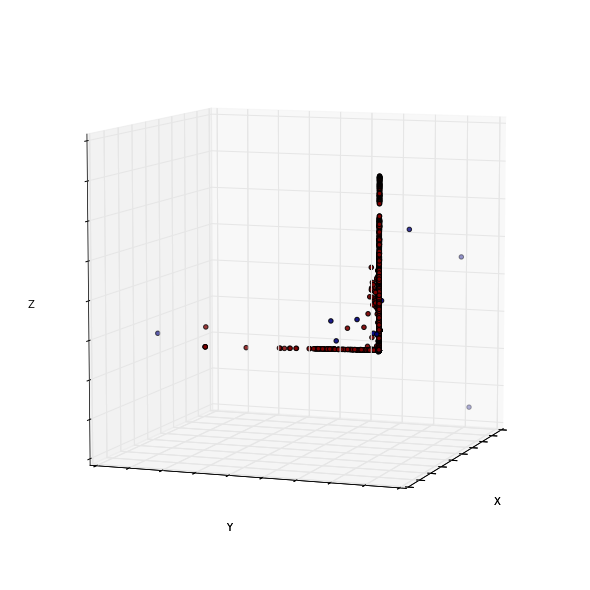

In [28]:
PlotData(data, 0.3, clusters)

<div class="alert alert-warning">


PUT YOUR ANSWER HERE !!!


</div>

### Note that: we only plot 30% samples on over whole dataset
#### Many points fall on top of one another, and the result is sparse and hard to interpret.
#### However, the dominant feature of the visualization is its "L" shape. The points seem to vary along two distinct dimensions, and little in other dimensions.
#### This could be explained that the dataset has two features that are on a much larger scale than others. Whereas most features have values between 0 and 1, the bytes-sent and bytes-received features vary from 0 to ten of thousands. The Euclidean distance between points is therefore almost complextely determined by these two features. It's almost as if the other features don't exist.
#### So it is important to normalize away these differences in scale to put features on near-equal footing

### 2.2.3. Evaluating model

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 4
<div class="alert alert-info">

One of the simplest method to evaluate our result is calculate the Within Set Sum of Squared Errors (WSSSE), or simply, 'Sum of Squared Errors'. An error of a data point is defined as it's distance to the closest cluster center.

</div>


from operator import add

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    closest_center = ...
    return ...

WSSSE = data.map(...).reduce(...)
print("Within Set Sum of Squared Error = " + str(WSSSE))


In [6]:
from operator import add

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    closest_center = clusters.centers[clusters.predict(point)]
    return euclidean_distance(point, closest_center)

In [7]:
WSSSE = data.map(lambda point: error(clusters, point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 20839996286.8


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)


#### Question 5

<div class="alert alert-info">

This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Complete the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs.  

What do you think about the result ?

</div>

In [8]:
clusterLabelCount = sorted(labelsAndData.map(lambda x: (clusters.predict(x[1]), x[0])).countByValue().items(), key = lambda xx: -xx[1])
for item in clusterLabelCount:
    print(item)

((0, 'smurf.'), 2807886)
((1, 'neptune.'), 1072016)
((1, 'normal.'), 857475)
((0, 'normal.'), 115306)
((1, 'satan.'), 15885)
((1, 'ipsweep.'), 12481)
((1, 'portsweep.'), 10403)
((1, 'nmap.'), 2316)
((0, 'back.'), 2203)
((1, 'teardrop.'), 979)
((1, 'warezclient.'), 897)
((0, 'pod.'), 264)
((0, 'warezclient.'), 123)
((1, 'guess_passwd.'), 53)
((1, 'buffer_overflow.'), 30)
((1, 'land.'), 21)
((1, 'warezmaster.'), 20)
((1, 'imap.'), 11)
((0, 'portsweep.'), 10)
((1, 'rootkit.'), 10)
((1, 'loadmodule.'), 9)
((0, 'satan.'), 7)
((1, 'multihop.'), 6)
((1, 'ftp_write.'), 6)
((1, 'phf.'), 4)
((1, 'perl.'), 3)
((0, 'ftp_write.'), 2)
((1, 'spy.'), 2)
((0, 'imap.'), 1)
((0, 'neptune.'), 1)
((0, 'multihop.'), 1)


<div class="alert alert-warning">

PUT YOUR COMMENT HERE

</div>

#### The result shows that the clustering was not at all helpful.
#### Only 5 data point of class "portsweep" end up in cluster 1. But class "portsweep" have 10413 elements. So seem all the data set endup in cluster 0.
#### Two clusters are plainly insufficient. In particular, for our own dataset, it's clear that there are 23 distinct classes, so it seems that k could be at least 23, or likely, even more.

### 2.2.4. Choosing K

How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of $k$. For doing that, we have to build and evaluate models with different values of $k$. A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 6
<div class="alert alert-info">
Complete the function below to calculate the MSE of each model that is corresponding to each value of $k$.  


Plot the results. From the obtained result, what is the best value for $k$ ? Why ?

</div>

```python
# k: the number of clusters
def clusteringScore(data, k):
    clusters = KMeans....
    # calculate mean square error
    return ...

scores = ...
for score in scores:
    print(score)
    
# plot results
plt...
```

In [9]:
# k: the number of clusters
def clusteringScore(data, k):
    clusters = KMeans.train(data, k, maxIterations=10, runs=10, initializationMode="random")
    # calculate mean square error
    score = data.map(lambda point: error(clusters, point)).mean()
    print(score)
    return score

/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


2804.29655045
1844.05113568
1509.07882849
1295.77079435
1644.77366449
1504.40799504
1154.35869962
1221.62991191
1087.65914232
1034.75981202
1104.99797165
1132.06954941
974.506564105
1016.31887953
986.173362524
987.782960595
1006.49100501
970.582837841
1100.4300048
960.623519384
950.45825672
966.524093519
922.265990589
956.308712282


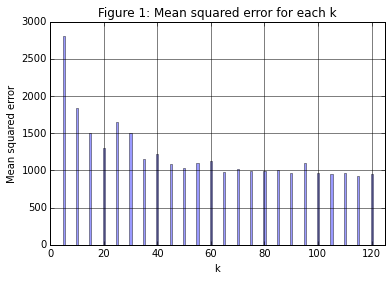

In [10]:
kList = range(5,121,5)
scores = list(map(lambda xk: (xk , clusteringScore(data, xk)), kList))

plt.xlabel("k")
plt.ylabel("Mean squared error")
plt.title('Figure 1: Mean squared error for each k')
plt.grid(True,which="both",ls="-")

npScores = np.array(scores)
plt.bar(npScores[:,0], npScores[:,1], align='center', alpha=0.4)
plt.xlim(0,125)
plt.show()

<div class="alert alert-warning">

PUT YOUR ANSWER HERE !

</div>

### 2.2.5 Normalizing features

K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias. 

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation

$normalize_i=\frac{feature_i - \mu_i}{\sigma_i}$

Where,

* $normalize_i$ is the normalized value of feature $i$
* $\mu_i$ is the mean of feature $i$
* $\sigma_i$ is the standard deviation of feature $i$


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 7
<div class="alert alert-info">

Complete the code below to normalize the data. Print the first 5 lines of the new data.

</div>

<div class="label label-success">HINT</div> If $\sigma_i = 0$ then $normalize_i=feature_i - \mu_i$

```python
def normalizeData(data):
    # number of connections
    n = ...

    # calculate the sum of each feature
    sums = ...
    print(sums)

    # calculate means
    means = ...

    # calculate the sum square of each feature
    sumSquares = ...
    print(sumSquares)

    # calculate standard deviation of each feature
    stdevs = ...
    print(stdevs)

    def normalize(point):
        return ...

    return data.map(normalize)

normalizedData = normalizeData(data).cache()
print(normalizedData.take(5))
```

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 8
<div class="alert alert-info">

Using the new data, build different models with different values of $k \in [60,70,80,90,100,110]$. Evaluate the results by plotting them and choose the best value of $k$.

</div>

```python
scores = ...
for score in scores:
    print(score)

plt...
```

<div class='alert alert-warning'>

PUT YOUR ANSWER HERE !!!

</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 9
<div class="alert alert-info">

Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

</div>

<div class="alert alert-warning">


PUT YOUR ANSWER HERE !!!

</div>

## 2.3. Clustering using categorical features

### 2.3.1 Loading data

In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering.
The problem is that K-means (or at least, the one we have developed and the one we use from MLLib) only work with data points in a metric space. Informally, this means that operations such as addition, substraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical features into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in $d$-dimensional vectors, and a nice way to do it is to use [word2vec](http://deeplearning4j.org/word2vec). If you're interested, follow this link to a nice [blog post](http://bigdatasciencebootcamp.com/posts/Part_3/clustering_news.html) on the problem.

There are two approaches:

* **Approach 1**: mapping **one** categorial feature to **one** numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* **Approach 2**: mapping mapping **one** categorial feature to **multiple** numerical features. Basically, a single variable with $n$ observations and $d$ distinct values, to $d$ binary variables with $n$ observations each. Each observation indicating the presence (1) or absence (0) of the $d^{th}$ binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes 
```
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
```

We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.



![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 10

<div class="alert alert-info">

Calculate the number of distinct categorical features value (at index `1,2,3`). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

</div>

```python
def parseLineWithHotEncoding(line):
    cols = line...
    # label is the last column
    label = ...
    
    vector = cols[0:-1]
    
    # the binary features that are encoded from the first categorial feature
    featureOfCol1 = ...
    # the binary features that are encoded from the second categorial feature
    featureOfCol2 = ...
    # the binary features that are encoded from the third categorial feature
    featureOfCol3 = ...
    
    # construct the new vector
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(...)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
data = labelsAndData.values().cache()


normalizedData = normalizeData(data).cache()
```

In [68]:
###@!SOLUTION@!####

# c: index of the column
def getValuesOfColumn(data, c):
    return data.map(lambda x: x[c]).distinct().collect()

vColumn1 = getValuesOfColumn(raw_data, 1)
numValuesColumn1 = len(vColumn1)
vColumn1 = dict(zip(vColumn1, range(0, numValuesColumn1)))


vColumn2 = getValuesOfColumn(raw_data, 2)
numValuesColumn2 = len(vColumn2)
vColumn2 = dict(zip(vColumn2, range(0, numValuesColumn2)))



vColumn3 = getValuesOfColumn(raw_data, 3)
numValuesColumn3 = len(vColumn3)
vColumn3 = dict(zip(vColumn3, range(0, numValuesColumn3)))




def parseLineWithHotEncoding(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    featureOfCol1 = [0]*numValuesColumn1
    featureOfCol2 = [0]*numValuesColumn2
    featureOfCol3 = [0]*numValuesColumn3
    featureOfCol1[vColumn1[vector[1]]] = 1
    featureOfCol2[vColumn2[vector[2]]] = 1
    featureOfCol3[vColumn3[vector[3]]] = 1
    
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(list(map(lambda x: float(x), vector)))
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
data = labelsAndData.values().cache()

In [71]:
###@!SOLUTION@!####
normalizedData = normalizeData(data).cache()

### 2.3.2. Building models

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 11
<div class="alert alert-info">

Using the new data, cluster the connections with different values of $k \in [80,90,100,110,120,130,140,150,160]$.
Evaluate the results and choose the best value of $k$ as previous questions.

</div>

```python
scores = list(...)
plt....
```

<div class="alert alert-warning">


PUT YOUR ANSWER HERE !!!


</div>

## 2.4. Anomaly detection
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide wheter there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 12
<div class="alert alert-info">

Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

</div>

<div class="label label-success">HINT</div> The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 13
<div class="alert alert-info">

Try other methods to find the best value for $k$ such as `silhouette`, `entropy`... In particular, with this data, you can take advantage of predefined labels to calculate the quality of model using entropy... However, we suggest you to try with `silhouette`. It's more general and can work with any dataset (with and without predefined labels).

</div>

Here are some additional information about the metrics we suggest to use:
- [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering))
- [Hack approach to Silhouette](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Entropy](http://scikit-learn.org/stable/modules/clustering.html) [Lookup for entropy]

<div class="label label-danger">Note</div> you are free to play with any relevant evaluation metric you think appropriate for your work!

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 14
<div class="alert alert-info">

Implement K-means on Spark so that It can work with large datasets in parallel. Test your algorithm with our dataset in this notebook. Compare our algorithm with the algorithm from MLLIB.  

<ul></ul>

Let's clarify the meaning of this question: what we want is for students to design the K-means algorithm for the parallel programming model exposed by Spark. You are strongly invited to use the Python API (pyspark). So, at the end of the day, you will operate on RDDs, and implement a `map/reduce` algorithm that performs the two phases of the standard K-means algorithm, i.e. the assignment step and the update step.

</div>